In [1]:
import pyspark as ps
import warnings

from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession

In [2]:
spark = SparkSession \
    .builder \
    .appName('SentimentAnalysis') \
    .getOrCreate()

In [3]:
data = spark.read.parquet('clean_tweets.parquet')

In [5]:
data.show()

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
|        0|awww that s a bum...|
|        0|is upset that he ...|
|        0|i dived many time...|
|        0|my whole body fee...|
|        0|no it s not behav...|
|        0|  not the whole crew|
|        0|          need a hug|
|        0|hey long time no ...|
|        0|nope they did not...|
|        0|        que me muera|
|        0|spring break in p...|
|        0|i just re pierced...|
|        0|i could not bear ...|
|        0|it it counts idk ...|
|        0|i would have been...|
|        0|i wish i got to w...|
|        0|hollis death scen...|
|        0| about to file taxes|
|        0|ahh ive always wa...|
|        0|oh dear were you ...|
+---------+--------------------+
only showing top 20 rows



In [6]:
data.filter(data.sentiment==4).show()

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
|        4|i love u guys r t...|
|        4|im meeting up wit...|
|        4|thanks for the tw...|
|        4|being sick can be...|
|        4|he has that effec...|
|        4|you can tell him ...|
|        4|thans for your re...|
|        4|i am so jealous h...|
|        4|ah congrats mr fl...|
|        4|i responded stupi...|
|        4|crazy day of scho...|
|        4|how did i forget ...|
|        4|haha do not worry...|
|        4|at least i will n...|
|        4|make sure you dm ...|
|        4|just added tweeti...|
|        4|i really do not k...|
|        4|your picture is v...|
|        4|catching up on em...|
|        4|dancing around th...|
+---------+--------------------+
only showing top 20 rows



In [7]:
data.count()

1600000

In [8]:
data.filter(data.text != '').count()

1596283

In [16]:
data = data.filter(data.text != '')

In [17]:
train_df, val_df, test_df = data.randomSplit([0.9, 0.05, 0.05], seed = 2000)

In [5]:
print("train data count: {0}\nvalidation data count: {1}\ntest data count: {2}"\
      .format(train_df.count(), val_df.count(), test_df.count()))

train data count: 1439849
validation data count: 80068
test data count: 80083


In [6]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [7]:
tokenizer = Tokenizer(inputCol='text', outputCol='words')
tf = HashingTF(inputCol='words', outputCol='tf')
idf = IDF(minDocFreq=5, inputCol='tf', outputCol='features')
label_idx = StringIndexer(inputCol='sentiment', outputCol='label')
pipeline = Pipeline(stages=[tokenizer, tf, idf, label_idx])

In [18]:
pipelineFit = pipeline.fit(train_df)
train_set = pipelineFit.transform(train_df)
val_set = pipelineFit.transform(val_df)

In [15]:
train_set.filter(train_df.sentiment==4).show(5)

+---------+--------------------+--------------------+--------------------+--------------------+-----+
|sentiment|                text|               words|                  tf|            features|label|
+---------+--------------------+--------------------+--------------------+--------------------+-----+
|        4|a beard is a grea...|[a, beard, is, a,...|(262144,[9017,158...|(262144,[9017,158...|  1.0|
|        4|a beautiful morni...|[a, beautiful, mo...|(262144,[1998,119...|(262144,[1998,119...|  1.0|
|        4|a beautifully des...|[a, beautifully, ...|(262144,[41170,59...|(262144,[41170,59...|  1.0|
|        4|a brand spanking ...|[a, brand, spanki...|(262144,[29945,17...|(262144,[29945,17...|  1.0|
|        4|a bright happy da...|[a, bright, happy...|(262144,[1672,139...|(262144,[1672,139...|  1.0|
+---------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [16]:
from pyspark.ml.classification import LogisticRegression
clf = LogisticRegression(maxIter=100)
clf_model = clf.fit(train_set)
predictions = clf_model.transform(val_set)

In [17]:
predictions.columns

['sentiment',
 'text',
 'words',
 'tf',
 'features',
 'label',
 'rawPrediction',
 'probability',
 'prediction']

In [18]:
predictions.filter(predictions.sentiment==4).select('sentiment', 'text', 'label', 'rawPrediction', 'prediction').show()

+---------+--------------------+-----+--------------------+----------+
|sentiment|                text|label|       rawPrediction|prediction|
+---------+--------------------+-----+--------------------+----------+
|        4|a mix i made if y...|  1.0|[-2.7747058024087...|       1.0|
|        4|    afternoon tweeps|  1.0|[-1.0369904330769...|       1.0|
|        4|also welcoming ne...|  1.0|[-1.1228841734686...|       1.0|
|        4|and another one j...|  1.0|[-1.4246836651099...|       1.0|
|        4|anyone tried game...|  1.0|[-2.2083665442775...|       1.0|
|        4|as details slowly...|  1.0|[-0.1062465132762...|       1.0|
|        4|as long as you ar...|  1.0|[0.68929538472486...|       0.0|
|        4|at all the shows ...|  1.0|[-2.7339951183549...|       1.0|
|        4|aw well aint u lo...|  1.0|[-0.3906026265254...|       1.0|
|        4|awwwww you must h...|  1.0|[-0.9197121875671...|       1.0|
|        4|battlefield heroe...|  1.0|[-2.1374268992547...|       1.0|
|     

In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.8647438662238691

In [20]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_df.count())
accuracy

0.7948281299274677

In [21]:
import matplotlib.pyplot as plt

In [22]:
%matplotlib inline

In [23]:
trainingSummary = clf_model.summary

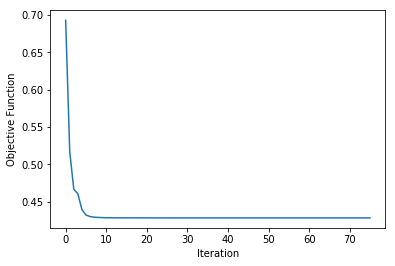

In [24]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

In [25]:
from pyspark.ml.classification import LinearSVC

In [ ]:
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

In [ ]:
pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

In [9]:
from pyspark.ml.classification import NaiveBayes

In [19]:
nb = NaiveBayes(smoothing=1)
model_nb = nb.fit(train_set)

In [20]:
predictions = model_nb.transform(val_set)

In [21]:
predictions.select('sentiment', 'text', 'label', 'prediction').show()

+---------+--------------------+-----+----------+
|sentiment|                text|label|prediction|
+---------+--------------------+-----+----------+
|        0|a bad day is some...|  0.0|       0.0|
|        0|a bobbi starrblas...|  0.0|       1.0|
|        0|a boring weekend ...|  0.0|       0.0|
|        0|a bug s life is s...|  0.0|       0.0|
|        0|a busy week ahead...|  0.0|       1.0|
|        0|a c in my car doe...|  0.0|       0.0|
|        0|           a c tweet|  0.0|       1.0|
|        0|a d or and e my c...|  0.0|       1.0|
|        0|a day full of hom...|  0.0|       0.0|
|        0|a fun evening but...|  0.0|       1.0|
|        0|a girl sitting in...|  0.0|       0.0|
|        0|a headache once a...|  0.0|       0.0|
|        0|a hot hazy and hu...|  0.0|       0.0|
|        0|a hour later afte...|  0.0|       1.0|
|        0|a keyboard cat no...|  0.0|       0.0|
|        0|a kiss though no ...|  0.0|       0.0|
|        0|a know a dont loo...|  0.0|       0.0|


In [22]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_df.count())
accuracy

0.767317561647265

In [23]:
from pyspark.ml.classification import LinearSVC

In [24]:
model_svc = LinearSVC(maxIter=10, regParam=0.1)

In [25]:
predictions_svc = model_svc.fit(train_set)